In [2]:
%matplotlib inline
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12,12

from utils import action2str, lake_annot, vi_frozen_lake

# Use seaborn style plots
sns.set()

# Set random generators seeds
np.random.seed(7)

# How can you estimate how good is your situation?
### *Or in RL language, what is the value of particural state?*

![frozen lake](refs/frozen_lake.jpg)

Consider "Frozen Lake" environment. You are a girl/boy who is tossing frisbee near to frozen lake (no matter how absurd this situation is). Wind gust throw your toy out into nearby lake. You want it back, but this is how ice on the lake present:

In [3]:
env = gym.make("FrozenLake8x8-v0")
env.seed(7)
n_states, n_actions = env.observation_space.n, env.action_space.n
lake_shape = (int(np.sqrt(n_states)), int(np.sqrt(n_states)))

print("States:", n_states, "Actions:", n_actions, "(left, down, right, up)")
print("(S: starting point, safe)")
print("(F: frozen surface, safe)")
print("(H: hole, fall to your doom)")
print("(G: goal, where the frisbee is located)")
env.render()

States: 64 Actions: 4 (left, down, right, up)
(S: starting point, safe)
(F: frozen surface, safe)
(H: hole, fall to your doom)
(G: goal, where the frisbee is located)

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


So, you just need to avoid holes and you are safe right? NO, this awful wind can kick you into the hole when you move and you are inevitably dead... until someone reset environment of course, then story begins from the starting point (magic of games). Fortunately, you live nearby and you know this place (and this wind) inside out, so you can tell with what probability wind will kick you off the ice into the hole while moving. Here is information about possible actions outcomes and reward that we get after each transition:

In [4]:
# MDP transition/dynamics
P = env.env.P

for s in range(n_states):
    print("### State {}x{} ###\n".format(int(s/np.sqrt(n_states)), int(s%np.sqrt(n_states))))
    for a in range(n_actions):
        is_terminal = False
        for p, s_, r, done in P[s][a]:
            if len(P[s][a]) == 1:
                print("TERMINAL STATE")
                is_terminal = True
            else:
                print("T(s=({}, {}), a={}, s'=({}, {})) = {:.2f} ;".format(int(s/np.sqrt(n_states)), int(s%np.sqrt(n_states)), action2str(a), int(s_/np.sqrt(n_states)), int(s_%np.sqrt(n_states)), p),
                      "R(s=..., a=..., s'=...) = {}".format("dead" if done and r == 0. else r))
        print("")
        if is_terminal:
            break

__NOTE__ = """Show them what MDP is, how is it formulated (T and R).
What terminal states are and seed idea of value (show that in some states death isn't possible)."""

### State 0x0 ###

T(s=(0, 0), a=L, s'=(0, 0)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(0, 0), a=L, s'=(0, 0)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(0, 0), a=L, s'=(1, 0)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0

T(s=(0, 0), a=D, s'=(0, 0)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(0, 0), a=D, s'=(1, 0)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(0, 0), a=D, s'=(0, 1)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0

T(s=(0, 0), a=R, s'=(1, 0)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(0, 0), a=R, s'=(0, 1)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(0, 0), a=R, s'=(0, 0)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0

T(s=(0, 0), a=U, s'=(0, 1)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(0, 0), a=U, s'=(0, 0)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(0, 0), a=U, s'=(0, 0)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0

### State 0x1 ###

T(s=(0, 1), a=L, s'=(0, 1)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(0, 1), a=L, s'=(0, 0)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(0, 1), a=L, s'=

T(s=(7, 2), a=D, s'=(7, 3)) = 0.33 ; R(s=..., a=..., s'=...) = dead

T(s=(7, 2), a=R, s'=(7, 2)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(7, 2), a=R, s'=(7, 3)) = 0.33 ; R(s=..., a=..., s'=...) = dead
T(s=(7, 2), a=R, s'=(6, 2)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0

T(s=(7, 2), a=U, s'=(7, 3)) = 0.33 ; R(s=..., a=..., s'=...) = dead
T(s=(7, 2), a=U, s'=(6, 2)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(7, 2), a=U, s'=(7, 1)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0

### State 7x3 ###

TERMINAL STATE

### State 7x4 ###

T(s=(7, 4), a=L, s'=(6, 4)) = 0.33 ; R(s=..., a=..., s'=...) = dead
T(s=(7, 4), a=L, s'=(7, 3)) = 0.33 ; R(s=..., a=..., s'=...) = dead
T(s=(7, 4), a=L, s'=(7, 4)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0

T(s=(7, 4), a=D, s'=(7, 3)) = 0.33 ; R(s=..., a=..., s'=...) = dead
T(s=(7, 4), a=D, s'=(7, 4)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0
T(s=(7, 4), a=D, s'=(7, 5)) = 0.33 ; R(s=..., a=..., s'=...) = 0.0

T(s=(7, 4), a=R, s'=(7, 4)) = 0.33 ; R(s=..., a=..., s'=...) = 0

As you can see, analysing raw statistics isn't easy. How can we summarize it? We want to know the value of each state... but what we value in this case?
## What we are looking for and how to formulate it mathematically?

```
__NOTE__ = """Value is expectance of how possible it is to get to the frisbee from particural state."""
```

#### *Pro tip*, this is how you formulate it mathematically:

For some arbitrary policy:

$$
V(s) = E[G_t | S_t = s] = E[R_t + R_{t+1} + R_{t+2} + ... + R_t | S_t = s] \\
V(s) = E[G_t | S_t = s] = E[R_t + G_{t+1} | S_t = s] = \sum_a \pi(a | s)\sum_{s'} T(s, a, s')\big[R_t + E[G_{t} | S_t = s']\big] = \text{...}
$$

*Recursive equation:*

$$
V(s) = \sum_a \pi(a | s)\sum_{s'} T(s, a, s')\big[R(s, a, s') + V(s')\big]
$$

For optimal policy (Bellman optimality equation):

$$
V^*(s) = \max_a\sum_{s'} T(s, a, s')\big[R(s, a, s') + V(s')\big]
$$

# Value Iteration

By turning Bellman optimality equation into update rule we can interativelly improve value estimation (start from random point e.g. zeros).

![value interation](refs/value.png)

Finished after 1672 iterations.


Text(0.5,1,'Frozen Lake map')

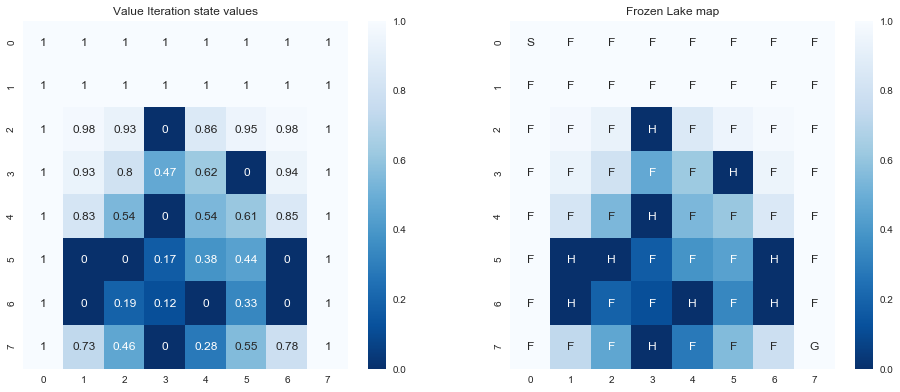

In [5]:
### TODO: Implement Value Iteration algorithm from pseudo-code above.
V = np.zeros(n_states)
iter = 0
while True:
    iter += 1
    delta = 0
    # Start from the end to speed value propagation
    for s in reversed(range(n_states)):
        oldV = V[s]
        V[s] = np.max([sum([p*(r + V[s_]) for p, s_, r, _ in P[s][a]]) for a in range(n_actions)])
        delta = max(delta, abs(oldV - V[s]))
    if delta < 1e-30:
        print("Finished after {} iterations.".format(iter))
        break

### PLOTING LOGIC - DO NOT TOUCH
# Overide value of goal state to make graph nicer
V[-1] = 1

fig = plt.figure(figsize=plt.figaspect(0.4))

ax = fig.add_subplot(1, 2, 1)
sns.heatmap(V.reshape(lake_shape), annot=True, cmap="Blues_r", ax=ax)
ax.set_title("Value Iteration state values")

ax = fig.add_subplot(1, 2, 2)
sns.heatmap(V.reshape(lake_shape), annot=lake_annot[0 if lake_shape[0] == 4 else 1], fmt='s', cmap="Blues_r", ax=ax)
ax.set_title("Frozen Lake map")

How we can use our learned values to behave optimaly? Like this:

$$\pi(a|s) = \text{argmax}_a\sum_{s'} T(s, a, s')\big[R(s, a, s') + V(s')\big]$$

Average score in 1000 Episodes: 0.892
Value of starting state: 1.000


False

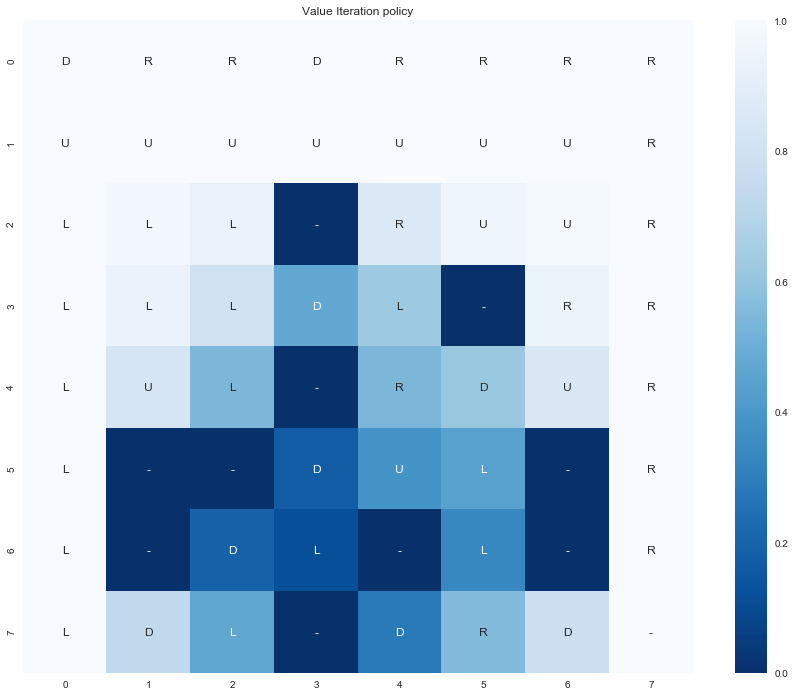

In [6]:
### PLOTING LOGIC - DO NOT TOUCH
pi = []
pi_str = []
for s in range(n_states):
    pi.append(np.argmax([sum([p*(r + V[s_]) for p, s_, r, _ in P[s][a]]) for a in range(n_actions)]))
    pi_str.append(action2str(pi[-1] if len(P[s][0]) > 1 else 5))

plt.figure(figsize=plt.figaspect(0.8))
ax = sns.heatmap(V.reshape(lake_shape), annot=np.array(pi_str).reshape(lake_shape), fmt='s', cmap="Blues_r")
ax.set_title("Value Iteration policy")
    
history = []
s = env.reset()
for _ in range(1000):
    while True:
        s, r, done, info = env.step(pi[s])

        if done:
            history.append(r)
            s = env.reset()
            break

print('Average score in 1000 Episodes: {:.3f}'.format(np.mean(history)))
print('Value of starting state: {:.3f}'.format(V[0]))

__NOTE__ == """Note that our policy is really safe. So safe that sometimes it doesn't make to the end!
OpenAI Gym has built in max step limit (200 steps) after which it kills poor girl/boy.
It also doesn't rush anywhere, that's why it really doesn't metter what policy will do in e.g. top row
of this board as long as it will get to the reward eventually. How could you change that? Discount factor!"""

# Q-Learning

What if we don't have access to perfect information (transition and reward functions) because... we don't know this neighbourhood (we've just moved in or something). What if we have only real world experiance for our disposal? We can learn online from samples!

![q-learning](refs/qlearn.png)

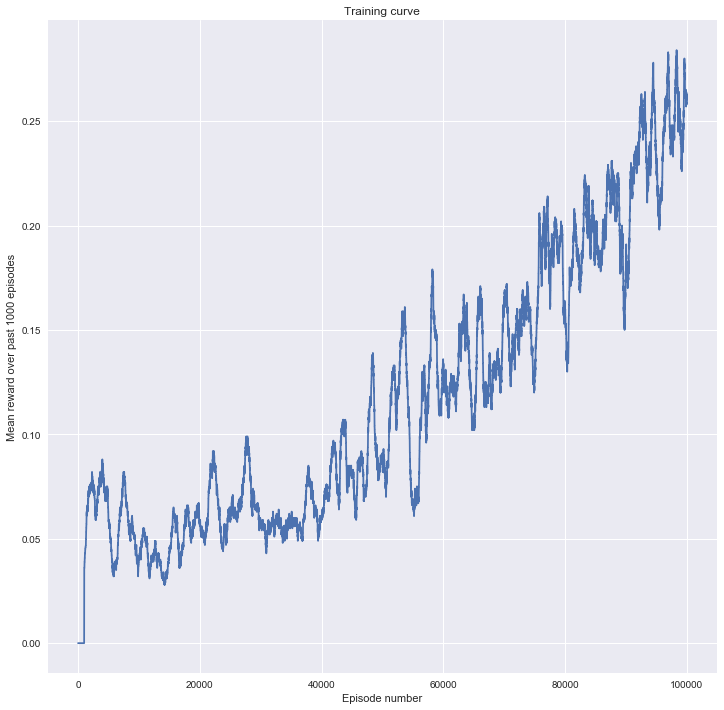

In [7]:
# Set up smaller lake
env = gym.make("FrozenLake-v0")
env.seed(7)
n_states, n_actions = env.observation_space.n, env.action_space.n
lake_shape = (int(np.sqrt(n_states)), int(np.sqrt(n_states)))
P = env.env.P

### TODO: Implement Tabular Q-Learning algorithm from figure above
# Hyper-parameters
NEPISODES = 100000
EPS = lambda x: x/NEPISODES # Decaying exploration rate
LR = .1

history = []
Q = np.zeros([n_states, n_actions])
for i in range(NEPISODES):
    old_Q = np.array(Q)
    s = env.reset()
    
    while True:
        # Choose action (decaying e-greedy) and take a step
        a = np.argmax(Q[s]) if np.random.randn() < EPS(i) else np.random.randint(n_actions)
        s_, r, done, info = env.step(a)
        
        # Update Q-table
        if done:
            target = r
        else:
            target = r + np.max(Q[s_])
        Q[s, a] += LR * (target - Q[s, a])
        
        s = s_    
        if done:
            history.append(r)
            break

### PLOTING LOGIC - DO NOT TOUCH ###
data = np.array(history)
X = np.arange(NEPISODES)
y = np.zeros(NEPISODES)
for i in range(1000, NEPISODES):
    y[i] = np.mean(data[i-1000:i])
    
plt.plot(X, y)
plt.title("Training curve")
plt.xlabel("Episode number")
plt.ylabel("Mean reward over past 1000 episodes")
plt.show()
    
__NOTE__ = """This is model-free learning. Value Iteration is model-based.
Note, that model-free learning needs much more iterations to converge."""

### Present Value and Policy

Text(0.5,1,'Value Iteration policy')

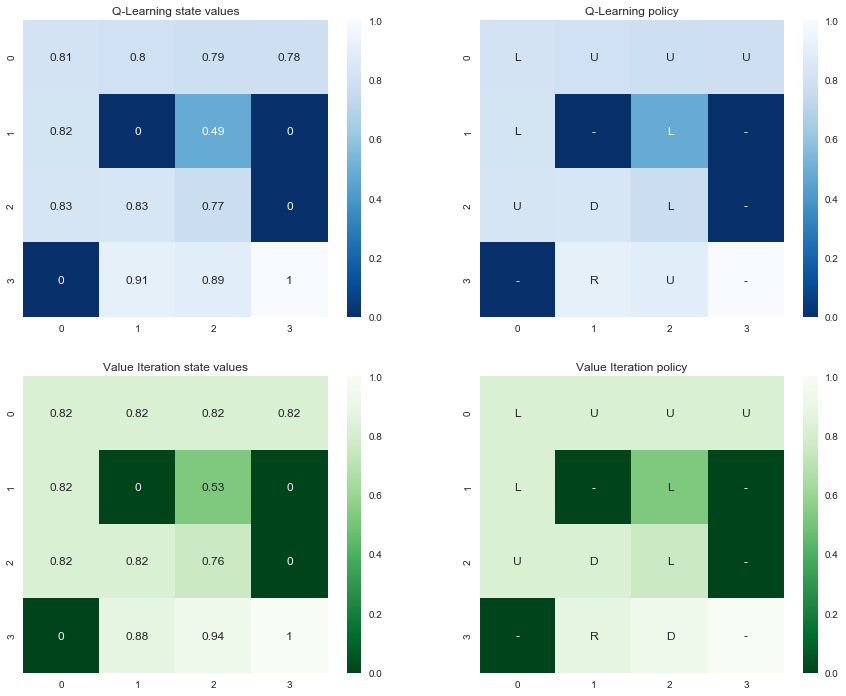

In [8]:
### PLOTING LOGIC - DO NOT TOUCH ###
fig = plt.figure(figsize=plt.figaspect(0.8))

V_ = np.zeros(n_states)
for s in range(n_states):
    V_[s] = np.max(Q[s])

# Overide value of goal state to make graph nicer
V_[-1] = 1

ax = fig.add_subplot(2, 2, 1)
sns.heatmap(V_.reshape(lake_shape), annot=True, cmap="Blues_r", ax=ax)
ax.set_title("Q-Learning state values")

pi_ = []
pi_str_ = []
for s in range(n_states):
    pi_.append(np.argmax(Q[s]))
    pi_str_.append(action2str(pi_[-1] if len(P[s][0]) > 1 else 5))
    
ax = fig.add_subplot(2, 2, 2)
sns.heatmap(V_.reshape(lake_shape), annot=np.array(pi_str_).reshape(lake_shape), fmt='s', cmap="Blues_r", ax=ax)
ax.set_title("Q-Learning policy")

# Present Value Iteration results
V, pi_str = vi_frozen_lake(env)

ax = fig.add_subplot(2, 2, 3)
sns.heatmap(V.reshape(lake_shape), annot=True, cmap="Greens_r", ax=ax)
ax.set_title("Value Iteration state values")
    
ax = fig.add_subplot(2, 2, 4)
sns.heatmap(V.reshape(lake_shape), annot=np.array(pi_str).reshape(lake_shape), fmt='s', cmap="Greens_r", ax=ax)
ax.set_title("Value Iteration policy")

# How it looks like in AlphaZero (planning)?

![AlphaZero eval function](refs/alphazero_dnn.png)

### Evaluation function

We use evaluation function that returns (estimated) value of the state and then use it to decide what parts of tree are worth to explore. How we get one?

### Training

Well, we look at game outcome (win, draw, lose) and then create dataset from it and all the states in played game. We just classify (using DNN) what is possible game outcome based on current state and past experience (number of wins, loses, draws in the past when this state was encountered). It's valid method and it's called "Direct Evaluation", but it ignores temporal information. So in short, in AlphaZero we don't do Value Iteration, we use simple classification. 

**But still, Value Iteration and TD-Learning concepts are widely utilised across RL domain so it's worth to know the basics! Don't thank me :)**

# References
* This hands-on was inspired by [wagonhelm/Value-Iteration](https://github.com/wagonhelm/Value-Iteration/blob/master/FrozenIce.ipynb).
* Figures come from "Mastering the Game of Go with Deep Neural Networks and Tree Search" paper and "Reinforcement Learning: An Introduction" book.